In [2]:
import mysql.connector
import pandas as pd
# import pandasql as ps
import matplotlib.pyplot as plt
# Import argsort
from numpy import argsort

In [7]:
creds = pd.read_csv('/Users/MarouanKamoun/Desktop/HGO pbl/credentials.csv')


In [5]:
creds = pd.read_csv('/Users/gabrielabib/Desktop/NOVA_SBE/PBL/credentials.csv')


In [9]:
#Connection to the database
host = creds['value'][0]
user = creds['value'][1]
password = creds['value'][2]
database = creds['value'][3]
port = creds['value'][4]
mydb = mysql.connector.connect(host=host, user=user, database=database, port=port, password=password, auth_plugin='mysql_native_password')
mycursor = mydb.cursor()
#Safecheck to guarantee that the connection worked
mycursor.execute('SHOW TABLES;')
print(f"Tables: {mycursor.fetchall()}")
print(mydb.connection_id) #it'll give connection_id,if got connected




Tables: [('ConsultaUrgencia_doentespedidosconsultaNeurologia2012',), ('consultaneurologia2012',), ('consultaneurologia201216anon_true',)]
860


In [10]:
alertP1 = pd.read_sql("""SELECT * FROM consultaneurologia201216anon_true""",mydb)
#changing columns with date to a datetime
alertP1["DATA_ENVIO"] = pd.to_datetime(alertP1["DATA_ENVIO"],dayfirst=True, yearfirst=False )
alertP1["DATA_RECEPCAO"] = pd.to_datetime(alertP1["DATA_RECEPCAO"],dayfirst=True, yearfirst=False)
alertP1["DATA_RETORNO"] = pd.to_datetime(alertP1[alertP1["DATA_RETORNO"]!='26/06/0214']["DATA_RETORNO"],dayfirst=True, yearfirst=False)
alertP1["DATA_REALIZACAO"] = pd.to_datetime(alertP1["DATA_REALIZACAO"],dayfirst=True, yearfirst=False)
alertP1["DATA_MARCACAO"] = pd.to_datetime(alertP1["DATA_MARCACAO"],dayfirst=True, yearfirst=False)
#change the blank values in proveniencia to unknown
alertP1['PROVENIENCIA'][alertP1['PROVENIENCIA']=='']='unknown'
alertP1['CTH_PRIOR'][alertP1['CTH_PRIOR']=='']='unknown'
#create a column with the output of a referral
alertP1['result']=['1' if x in [0,14,15,53,8,12,13] else '0' if x in [1,6,10,7] else '' for x in alertP1['COD_MOTIVO_RECUSA'] ]
#create a list with code of units inside area
area_list=[3150502,3151672,3150671,3150572,3150305,3150571,3151571,3151574,3150371,3151573,3150672,3152401,3150605,3152471,3151575,3151671,3151601,3150573,3151576,3150506,3150504,3152400,3150501,3150603,3150604,3151707,999999,3152403,3151603,3151500,3150503,3150330,3150600]
#create a column with area of the unit
alertP1['area']=['inside area' if x in area_list else 'outside area' for x in alertP1['COD_UNID_SAUDE_PROV'] ]
#compute length of text
alertP1['text_length']=alertP1['Texto'].str.len()
#step of referral(first or second or3+)
alertP1['step']=alertP1.sort_values(by=['DATA_RECEPCAO']).groupby('ID_DOENTE').cumcount()+1
alertP1['step'][alertP1['step']>=3]='3+'
#speciality 
alertP1['speciality_type'] = ['General Neurology' if x == 'NEUROLOGIA' else 'Other specialities'  for x in alertP1['DES_ESPECIALIDADE']]
#create a list with units 
USF_list=[2090771,3111172,3111174,3112271,3113271,3113274,3113672,3113871,3114272,3114471,3150371,3150571,3150572,3150573,3150872,3151571,3151572,3151573,3151574,3151575,3151576,3151671,3151672,3151771,3151772,3151871,3151872,3152403,3152471,3152671,4070571,4070671,4121571]
UCSP_list=[3150305,3150506,3151701,3151707,3151802,3152401]
#create a column with units
alertP1['unit']=['USF' if x in USF_list else 'UCSP' if x in UCSP_list else 'CS' for x in alertP1['COD_UNID_SAUDE_PROV']]
alertP1['unit'][alertP1['TIPO_UNID']!='CS/USF']='HOSP'

alertP1.head()

C:\Users\MAROUA~1\AppData\Local\Temp/ipykernel_9308/2847612731.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['PROVENIENCIA'][alertP1['PROVENIENCIA']=='']='unknown'
C:\Users\MAROUA~1\AppData\Local\Temp/ipykernel_9308/2847612731.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['CTH_PRIOR'][alertP1['CTH_PRIOR']=='']='unknown'
C:\Users\MAROUA~1\AppData\Local\Temp/ipykernel_9308/2847612731.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

,ID_DOENTE,PROCESSO,COD_REFERENCIA,COD_PZ,COD_UNID_SAUDE_PROV,UNID_PROV,TIPO_UNID,PROVENIENCIA,COD_CTH_PRIOR,CTH_PRIOR,...,resume saída,mês_saida,ano_saida,Texto,result,area,text_length,step,speciality_type,unit
0,SSHCCB,LVMVDV,LQHSOQLH,GDCADAB,3151575,USF TORRE DA MARINHA,CS/USF,CTH,3,Normal,...,12/06/2015,6,2015,"Utente de 75 anos, refere tremor desde há 5 an...",1,inside area,701,1,General Neurology,USF
1,CSAS,LVMVBD,LOHLTRTS,FZFZSDB,3152471,USF SERVIR SAUDE-CS,CS/USF,CTH,,unknown,...,02/07/2012,7,2012,Avaliação neurologica para avaliação da toma d...,1,inside area,363,1,General Neurology,USF
2,ADCFD,LVMMVJ,LQHROQHL,,0,,OUTRA,SAM,,unknown,...,13/01/2015,1,2015,cefaleias,1,outside area,9,1,Other specialities,HOSP
3,SSZDBZ,LVMMLV,LPHQULSU,CSGGHEZ,3151672,USF AMORA SAUDAVEL,CS/USF,CTH,,unknown,...,03/12/2013,12,2013,"Utente do sexo feminino com 30 anos de idade, ...",1,inside area,417,1,General Neurology,USF
4,SEAHEG,LVMNDL,LPHHVHVL,,0,,OUTRA,unknown,,unknown,...,26/02/2013,2,2013,Sem relatorio clinico,0,outside area,22,1,General Neurology,HOSP


In [14]:
accepted=alertP1[alertP1['result']=='1']['ID_DOENTE'].groupby(alertP1['step']).count().reset_index().rename(columns={"ID_DOENTE":"number_of_acceptance"})
total_referrals = alertP1['ID_DOENTE'].groupby(alertP1['step']).count().reset_index().rename(columns={"ID_DOENTE":"number_of_referrals"})
total_referrals
#divide the number of referrals for each specialty and priority level by the total number of referrals for that specialty, then multiply by 100 to get the percentage
accepted['percentage'] = round(accepted['number_of_acceptance'] / total_referrals['number_of_referrals'] * 100)
accepted

,step,number_of_acceptance,percentage
0,1,4985,61.0
1,2,1029,66.0
2,3+,240,61.0


In [15]:
#converting categorical features
data=alertP1.copy()
data=data[data['result']!='']
area = pd.get_dummies(data['area'],drop_first=True)
Provenance = pd.get_dummies(data['PROVENIENCIA'],drop_first=True)
speciality_type = pd.get_dummies(data['speciality_type'],drop_first=True)
step= pd.get_dummies(data['step'],drop_first=True)
unit= pd.get_dummies(data['unit'],drop_first=True)
data.drop(['area','PROVENIENCIA','speciality_type','step','unit'],axis=1,inplace=True)
data = pd.concat([data,area,Provenance,speciality_type,step,unit],axis=1)
data
#cross tab

,ID_DOENTE,PROCESSO,COD_REFERENCIA,COD_PZ,COD_UNID_SAUDE_PROV,UNID_PROV,TIPO_UNID,COD_CTH_PRIOR,CTH_PRIOR,COD_MOTIVO_RECUSA,...,outside area,SAM,SON,unknown,Other specialities,2,3+,HOSP,UCSP,USF
0,SSHCCB,LVMVDV,LQHSOQLH,GDCADAB,3151575,USF TORRE DA MARINHA,CS/USF,3,Normal,0,...,0,0,0,0,0,0,0,0,0,1
1,CSAS,LVMVBD,LOHLTRTS,FZFZSDB,3152471,USF SERVIR SAUDE-CS,CS/USF,,unknown,0,...,0,0,0,0,0,0,0,0,0,1
2,ADCFD,LVMMVJ,LQHROQHL,,0,,OUTRA,,unknown,0,...,1,1,0,0,1,0,0,1,0,0
3,SSZDBZ,LVMMLV,LPHQULSU,CSGGHEZ,3151672,USF AMORA SAUDAVEL,CS/USF,,unknown,0,...,0,0,0,0,0,0,0,0,0,1
4,SEAHEG,LVMNDL,LPHHVHVL,,0,,OUTRA,,unknown,1,...,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10144,GSHADS,,LSHRSQTV,ZDCECBSE,9999999,UNIDADE ALERT-P,CS/USF,,unknown,7,...,1,0,0,0,0,0,0,0,0,0
10146,GSFFSC,,LSHTPHVS,ZEHGFBSH,3151104,MIGUEL BOMBARDA,CS/USF,,unknown,7,...,1,0,0,0,0,0,0,0,0,0
10147,GSCHDB,,LSHTVPOP,,0,,OUTRA,,unknown,1,...,1,1,0,0,0,0,0,1,0,0
10148,GSBZAA,,LSHUQOPP,ZEESAADG,3151101,ALHOS VEDROS,CS/USF,,unknown,7,...,1,0,0,0,0,0,0,0,0,0


[[-0.38665018  0.23960957 -1.44573298 -0.83800564  3.44711282  0.41011802
   0.34428499 -0.72902492 -0.13982516  0.44068859]] [0.92306495]
Accuracy of the train set: 0.7386609071274298
Recall of the train set: 0.6271726113680423
Precision of the train set: 0.7436797303216376
Accuracy: 0.7381209503239741
Recall: 0.6140035199600202
Precision: 0.7209213279122093
              precision    recall  f1-score   support

     refused       0.70      0.28      0.40       578
    accepted       0.74      0.94      0.83      1274

    accuracy                           0.74      1852
   macro avg       0.72      0.61      0.62      1852
weighted avg       0.73      0.74      0.70      1852



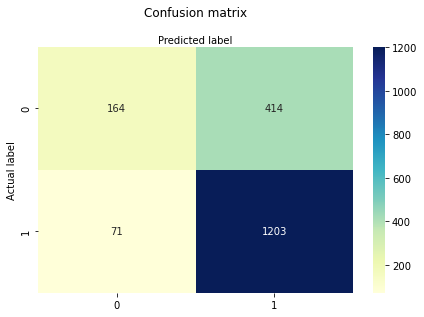

In [29]:
#logistic regression whole dataset
# import the class
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#split dataset in features and target variable// Question: is it the right option?
eliminate_cols=['text_length','ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto']
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=16)

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
clf=logreg.fit(X_train, y_train)
print(clf.coef_, clf.intercept_)
y_pred = logreg.predict(X_test)

# Evaluate the accuracy of the train set
accuracy = accuracy_score(y_train, logreg.predict(X_train))
print("Accuracy of the train set:", accuracy)

# Evaluate the recall of the train set
recall = recall_score(y_train,logreg.predict(X_train), average='macro')
print("Recall of the train set:", recall)
# Evaluate the precision of the train set
precision = precision_score(y_train, logreg.predict(X_train), average='macro')
print("Precision of the train set:", precision)


# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Evaluate the recall of the model
recall = recall_score(y_test, y_pred, average='macro')
print("Recall:", recall)
# Evaluate the precision of the model
precision = precision_score(y_test, y_pred, average='macro')
print("Precision:", precision)

# Calculate the confusion matrix of the model
cnf_matrix = confusion_matrix(y_test, y_pred)


class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# Print the evaluation matrix
target_names = ['refused', 'accepted']
print(classification_report(y_test, y_pred, target_names=target_names))

In [14]:
#p value 
from sklearn.feature_selection import f_classif
# Calculate the p-value for each feature
f_values, p_values = f_classif(X, y)

# Print the p-values for each feature
print("P-values for each feature:")
for i, p_value in enumerate(p_values):
    print(f"Feature {i}: {p_value}")

P-values for each feature:
Feature 0: 0.0
Feature 1: 4.163195311358619e-15
Feature 2: 0.0
Feature 3: 0.0
Feature 4: 0.0
Feature 5: 6.358913395843047e-11
Feature 6: 0.006346844136714935
Feature 7: 0.0
Feature 8: 0.014854189939796925
Feature 9: 0.0


c:\Users\MarouanKamoun\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[ 1.61981921e-03  2.71399403e-01  3.14757947e-03 -1.14526904e-01
  -7.02803375e-01  3.32757513e+00  3.22465073e-01  4.83021169e-01
  -8.14182699e-01 -2.67718384e-01  6.75488209e-02]] [0.21127227]
Accuracy of the train set: 0.7458952306489445
Recall of the train set: 0.666207987213255
Precision of the train set: 0.7106169634642951
Accuracy: 0.78125
Recall: 0.6941266209000763
Precision: 0.7376283846872083
              precision    recall  f1-score   support

     refused       0.66      0.49      0.56        92
    accepted       0.81      0.90      0.85       228

    accuracy                           0.78       320
   macro avg       0.74      0.69      0.71       320
weighted avg       0.77      0.78      0.77       320



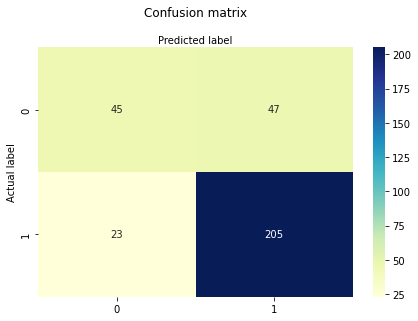

In [38]:
#logistic regression text rows
data=data[data['text_length']>0]
#split dataset in features and target variable// Question: is it the right option?
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto']
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=16)

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
clf=logreg.fit(X_train, y_train)
print(clf.coef_, clf.intercept_)
y_pred = logreg.predict(X_test)

# Evaluate the accuracy of the train set
accuracy = accuracy_score(y_train, logreg.predict(X_train))
print("Accuracy of the train set:", accuracy)

# Evaluate the recall of the train set
recall = recall_score(y_train,logreg.predict(X_train), average='macro')
print("Recall of the train set:", recall)
# Evaluate the precision of the train set
precision = precision_score(y_train, logreg.predict(X_train), average='macro')
print("Precision of the train set:", precision)


# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Evaluate the recall of the model
recall = recall_score(y_test, y_pred, average='macro')
print("Recall:", recall)
# Evaluate the precision of the model
precision = precision_score(y_test, y_pred, average='macro')
print("Precision:", precision)

# Calculate the confusion matrix of the model
cnf_matrix = confusion_matrix(y_test, y_pred)


class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# Print the evaluation matrix
target_names = ['refused', 'accepted']
print(classification_report(y_test, y_pred, target_names=target_names))


In [39]:
#p value 
from sklearn.feature_selection import f_classif
# Calculate the p-value for each feature
f_values, p_values = f_classif(X, y)

# Print the p-values for each feature
print("P-values for each feature:")
for i, p_value in enumerate(p_values):
    print(f"Feature {i}: {p_value}")

P-values for each feature:
Feature 0: 2.568252059259589e-30
Feature 1: 4.194272071043521e-27
Feature 2: 0.0001991165406153175
Feature 3: 0.0013318358062624001
Feature 4: 2.500977290998093e-32
Feature 5: 3.2181341784359195e-23
Feature 6: 0.0015928597103137038
Feature 7: 0.09026709375608065
Feature 8: 1.7980692522871387e-33
Feature 9: 0.1727415578910221
Feature 10: 4.827285945236599e-18


Accuracy of the train set: 0.7350161987041036
Recall of the train set: 0.622218056082535
Precision of the train set: 0.7346495370944608
Accuracy: 0.7526997840172787
Recall: 0.6343108088964442
Precision: 0.7582326650359138


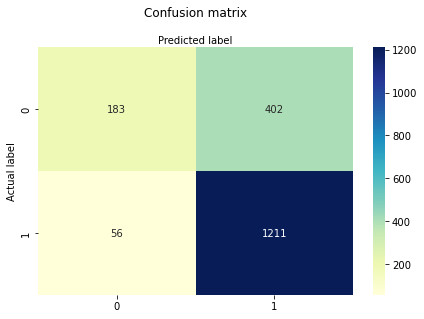

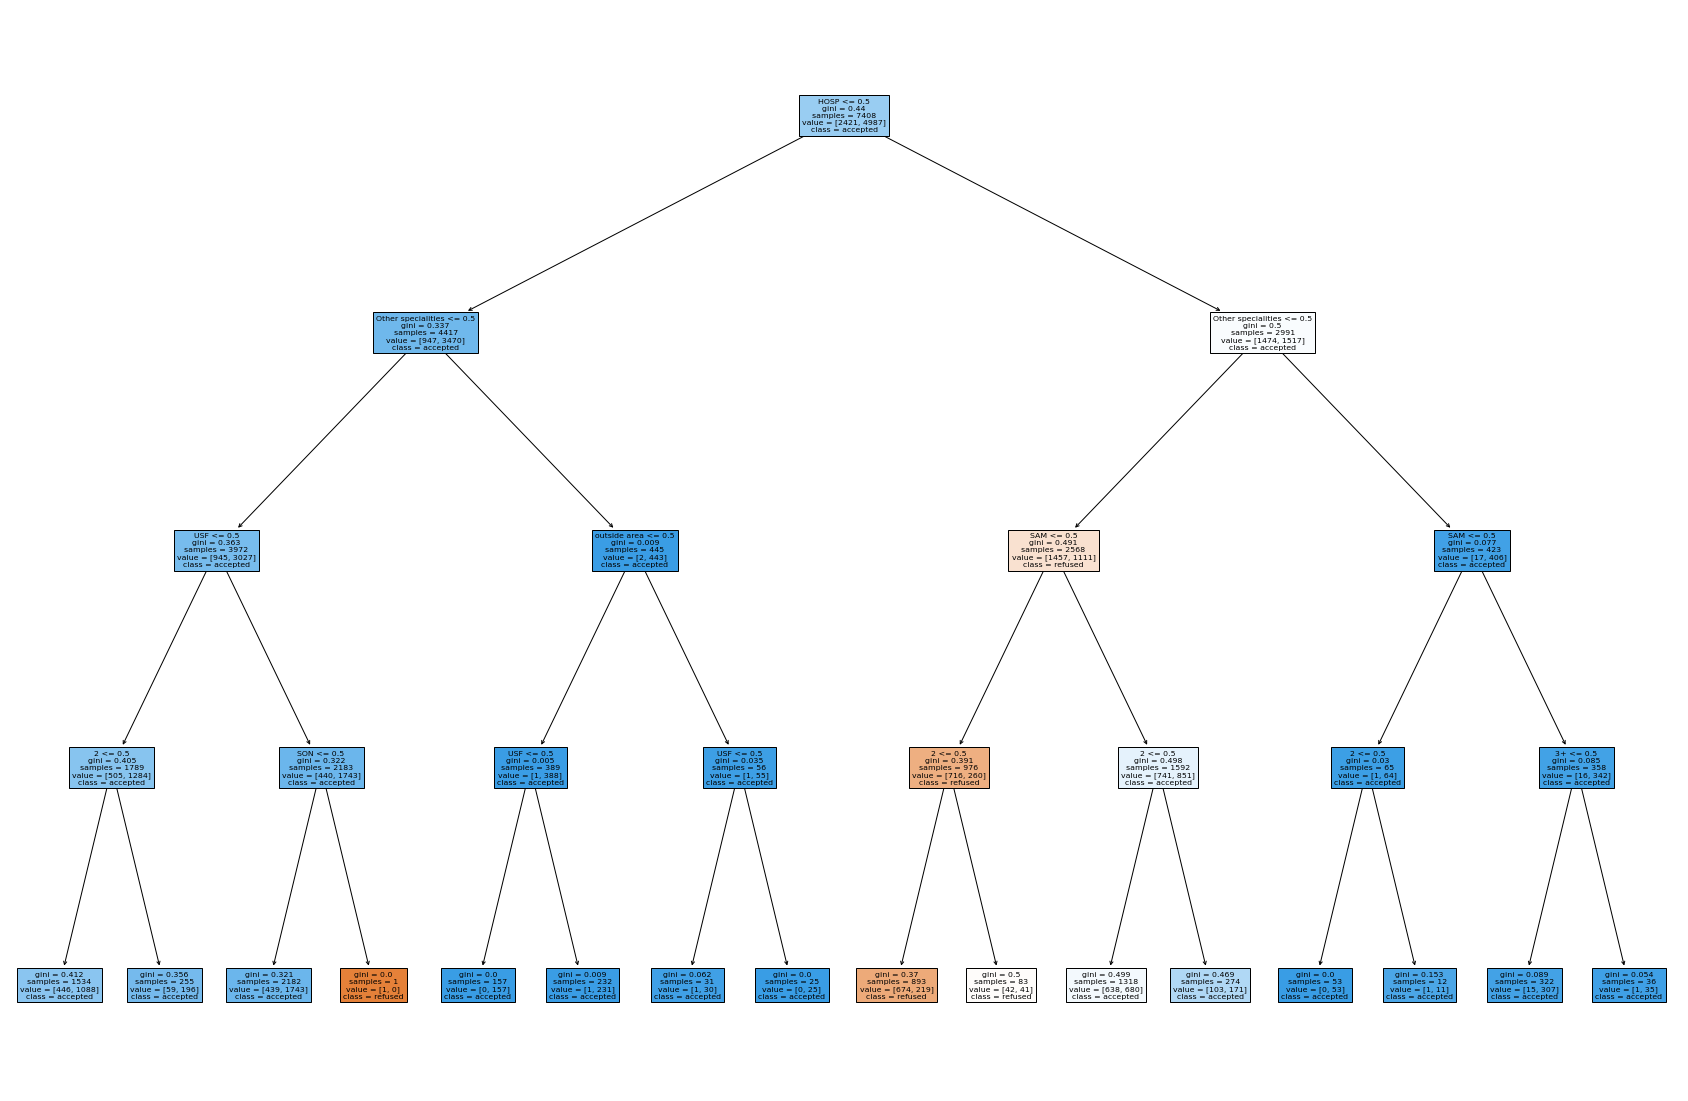

              precision    recall  f1-score   support

    accepted       0.77      0.31      0.44       585
     refused       0.75      0.96      0.84      1267

    accuracy                           0.75      1852
   macro avg       0.76      0.63      0.64      1852
weighted avg       0.76      0.75      0.72      1852



In [30]:
# Decision Tree classification model for whole dataset

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report

#split dataset in features and target variable
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto', 'text_length']
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
features = list(X.columns)
# feature_cols = ['text_length','outside area','SAM','SON','unknown','Other specialities']
# X = data[feature_cols] # Features
# y = data.result # Target variable

# Split the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a decision tree classifier
clf = DecisionTreeClassifier(max_depth=4, random_state = 42)
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the train set
accuracy = accuracy_score(y_train, logreg.predict(X_train))
print("Accuracy of the train set:", accuracy)

# Evaluate the recall of the train set
recall = recall_score(y_train,logreg.predict(X_train), average='macro')
print("Recall of the train set:", recall)
# Evaluate the precision of the train set
precision = precision_score(y_train, logreg.predict(X_train), average='macro')
print("Precision of the train set:", precision)


# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Evaluate the recall of the model
recall = recall_score(y_test, y_pred, average='macro')
print("Recall:", recall)

# Evaluate the precision of the model
precision = precision_score(y_test, y_pred, average='macro')
print("Precision:", precision)

# Calculate the confusion matrix of the model
cm = confusion_matrix(y_test, y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Visualize the decision tree
plt.figure(figsize=(30, 20))
plot_tree(clf, feature_names= features, class_names=['refused', 'accepted'], filled=True)
plt.show()

# Print the evaluation matrix
target_names = ['accepted', 'refused']
print(classification_report(y_test, y_pred, target_names=target_names))

Accuracy of the train set: 0.7521501172791243
Recall of the train set: 0.6661326875733382
Precision of the train set: 0.7103314180848972
Accuracy: 0.75
Recall: 0.6705101327742837
Precision: 0.73828125


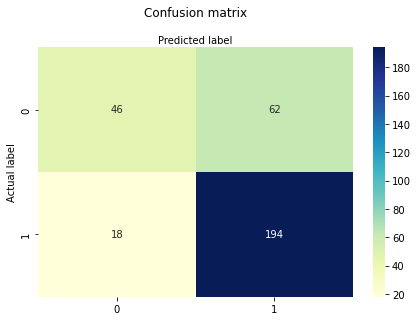

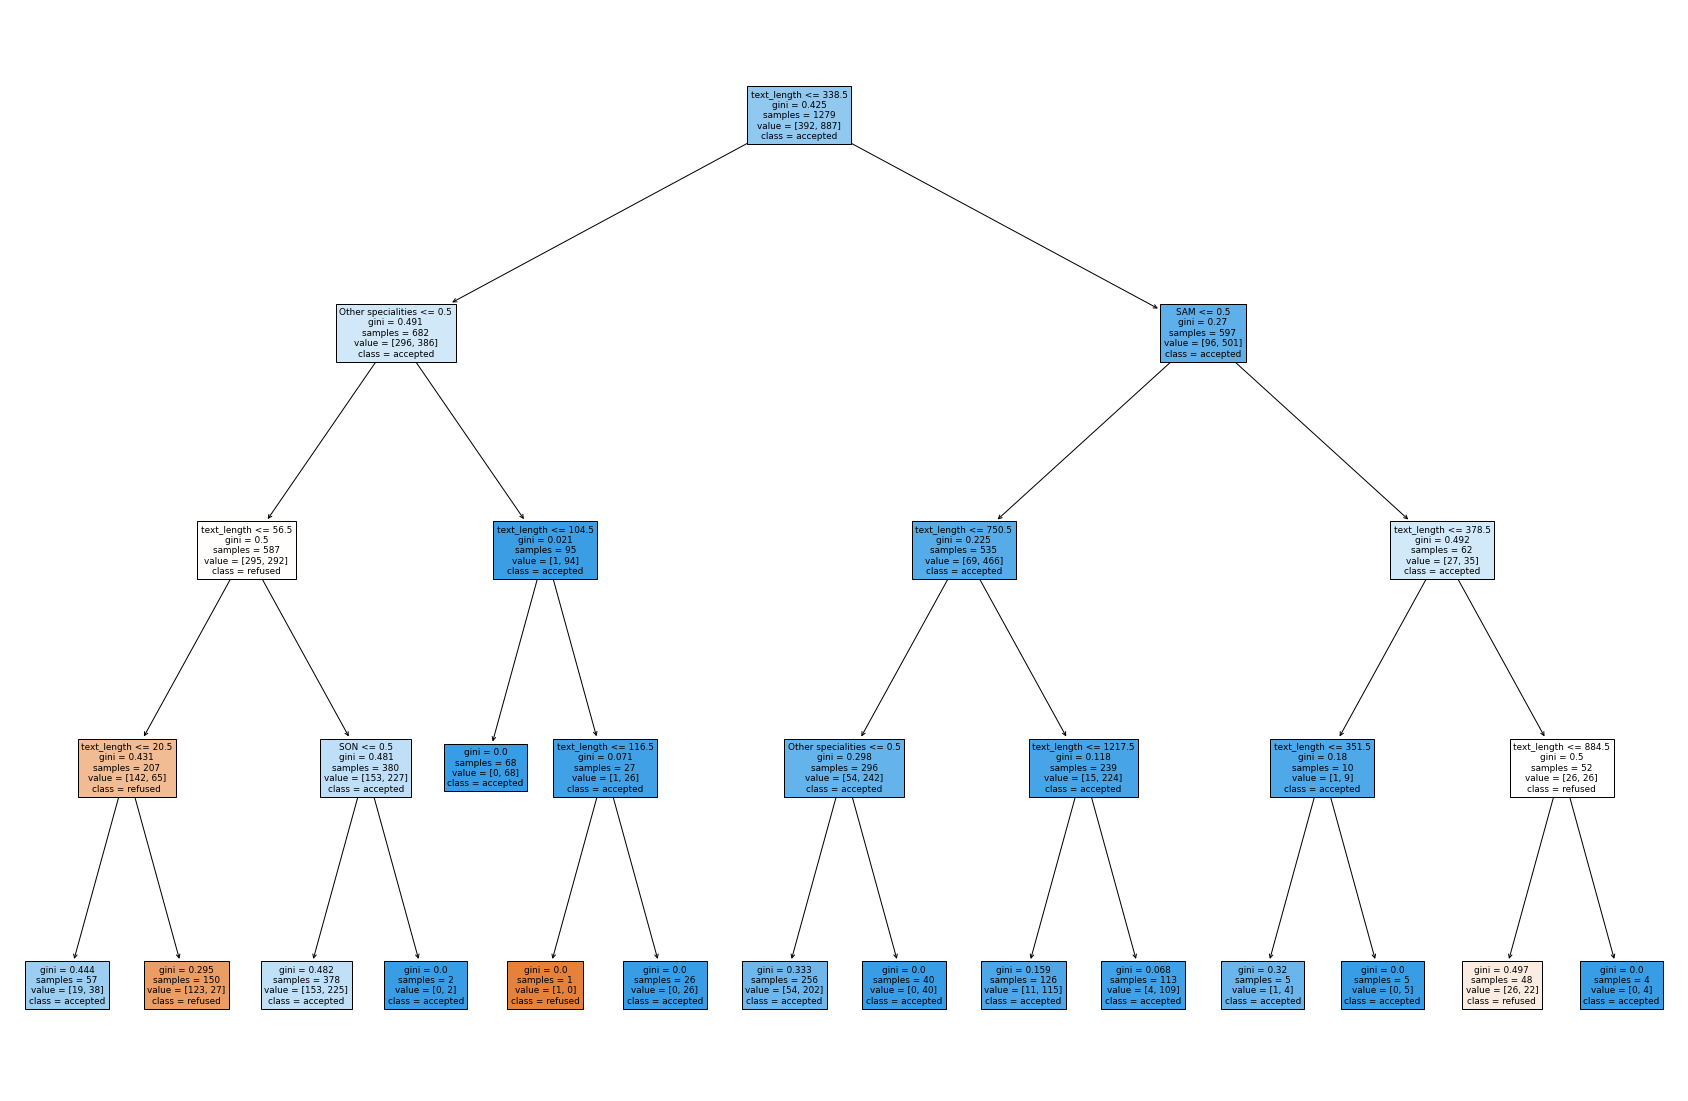

              precision    recall  f1-score   support

    accepted       0.72      0.43      0.53       108
     refused       0.76      0.92      0.83       212

    accuracy                           0.75       320
   macro avg       0.74      0.67      0.68       320
weighted avg       0.74      0.75      0.73       320



In [40]:
# Decision Tree classification model for text rows
data=data[data['text_length']>0]
#split dataset in features and target variable
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto']
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
features = list(X.columns)
# feature_cols = ['text_length','outside area','SAM','SON','unknown','Other specialities']
# X = data[feature_cols] # Features
# y = data.result # Target variable

# Split the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a decision tree classifier
clf = DecisionTreeClassifier(max_depth=4, random_state = 42)
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the train set
accuracy = accuracy_score(y_train, logreg.predict(X_train))
print("Accuracy of the train set:", accuracy)

# Evaluate the recall of the train set
recall = recall_score(y_train,logreg.predict(X_train), average='macro')
print("Recall of the train set:", recall)
# Evaluate the precision of the train set
precision = precision_score(y_train, logreg.predict(X_train), average='macro')
print("Precision of the train set:", precision)


# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Evaluate the recall of the model
recall = recall_score(y_test, y_pred, average='macro')
print("Recall:", recall)

# Evaluate the precision of the model
precision = precision_score(y_test, y_pred, average='macro')
print("Precision:", precision)

# Calculate the confusion matrix of the model
cm = confusion_matrix(y_test, y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Visualize the decision tree
plt.figure(figsize=(30, 20))
plot_tree(clf, feature_names= features, class_names=['refused', 'accepted'], filled=True)
plt.show()

# Print the evaluation matrix
target_names = ['accepted', 'refused']
print(classification_report(y_test, y_pred, target_names=target_names))